## Urbanization Analysis for Kurunegala District - Enhanced Multi-Index Detection

This notebook performs detailed monthly urbanization analysis for **Kurunegala District**, Sri Lanka using Landsat satellite data from 2013-2025.

### 🎯 **Analysis Overview**

**Purpose**: Track urban expansion and urbanization patterns over time using satellite imagery to understand:
- Monthly urbanization trends with enhanced accuracy
- Seasonal variations in urban area detection
- Long-term urban area change patterns
- Urban growth detection between time periods

**Data Source**: Landsat Surface Reflectance data
- **Temporal Coverage**: Multi-year analysis (2013-2025)
- **Spatial Resolution**: 30m pixels
- **Processing**: Monthly scenes processed individually with quality control
- **Area of Interest**: Kurunegala district polygon

### 🔬 **Enhanced Urban Detection Method**
Uses **4 spectral indices** for robust urban classification:
1. **NDBI** (Normalized Difference Built-up Index) - Detects built-up areas
2. **NDVI** (Normalized Difference Vegetation Index) - Excludes vegetation
3. **UI** (Urban Index) - Additional urban signature using SWIR2
4. **MNDWI** (Modified Normalized Difference Water Index) - Excludes water bodies

### 📊 **Key Outputs**
1. **Monthly Statistics**: CSV file with comprehensive urbanization metrics
2. **Temporal Visualizations**: Multiple trend charts with Sri Lankan seasonal analysis
3. **Raster Products**: NDVI, NDBI, UI, MNDWI, and urban classification maps
4. **Change Maps**: Detailed urban expansion analysis
5. **Seasonal Analysis**: Sri Lankan monsoon season-based patterns

In [1]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from datetime import datetime

print("="*70)
print("URBANIZATION ANALYSIS FOR KURUNEGALA DISTRICT".center(70))
print("="*70)

# ===========================
# CONFIGURATION
# ===========================
BASE_DIR = r"D:\Satellite Image Processing\Satellite Images"
AOI_PATH = r"D:\Satellite Image Processing\Urbanization_Kurunegala\AOI\kurunegala_District_AOI.geojson"
OUTPUT_DIR = r"D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly"
os.makedirs(OUTPUT_DIR, exist_ok=True)

YEARS = range(2013, 2026)
BANDS = {
    "blue": "SR_B2.TIF",
    "green": "SR_B3.TIF", 
    "red": "SR_B4.TIF",
    "nir": "SR_B5.TIF",
    "swir1": "SR_B6.TIF",  # SWIR1 for NDBI and MNDWI
    "swir2": "SR_B7.TIF",  # SWIR2 for Urban Index
    "qa_pixel": "QA_PIXEL.TIF"
}

# Urban classification thresholds for robust identification
URBAN_THRESHOLDS = {
    'ndbi_min': 0.0,      # Built-up areas have NDBI > 0
    'ndvi_max': 0.3,      # Urban areas have low vegetation (NDVI < 0.3)
    'ui_min': 0.0,        # Urban Index > 0
    'mndwi_max': 0.0      # Exclude water bodies (MNDWI < 0)
}

# LOAD AOI
aoi = gpd.read_file(AOI_PATH)
print(f"\n✅ AOI loaded: {len(aoi)} administrative division(s)")
print(f"   CRS: {aoi.crs}")
print(f"   Total area: {aoi.geometry.area.sum() / 1e6:.2f} km²")

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def clip_to_aoi(raster_path, aoi_geom, target_crs, preserve_int=False):
    """Clip raster to AOI boundary
    
    Args:
        raster_path: Path to raster file
        aoi_geom: GeoDataFrame with AOI geometry
        target_crs: Target CRS for reprojection
        preserve_int: If True, keep as uint16 (for QA_PIXEL), else convert to float32
    """
    with rasterio.open(raster_path) as src:
        aoi_reprojected = aoi_geom.to_crs(target_crs)
        out_img, out_transform = mask(src, aoi_reprojected.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform
        })
    
    if preserve_int:
        return out_img[0].astype("uint16"), out_meta
    else:
        return out_img[0].astype("float32"), out_meta

def create_quality_mask(qa_pixel):
    """Create quality mask from Landsat Collection 2 QA_PIXEL band
    
    Decodes bit-packed quality flags to identify clear, usable pixels.
    
    Args:
        qa_pixel: QA_PIXEL band array (uint16)
    
    Returns:
        Boolean mask where True = clear/valid pixel, False = invalid/cloudy pixel
    
    Filters out:
        - Fill/NoData (bit 0 = 1)
        - Dilated Cloud (bit 1 = 1)
        - Cirrus (bit 2 = 1)
        - Cloud (bit 3 = 1)
        - Cloud Shadow (bit 4 = 1)
    """
    clear_mask = (
        ((qa_pixel & (1 << 0)) == 0) &  # Not Fill
        ((qa_pixel & (1 << 1)) == 0) &  # Not Dilated Cloud
        ((qa_pixel & (1 << 2)) == 0) &  # Not Cirrus
        ((qa_pixel & (1 << 3)) == 0) &  # Not Cloud
        ((qa_pixel & (1 << 4)) == 0)    # Not Cloud Shadow
    )
    
    return clear_mask

def extract_date_from_filename(filename):
    """Extract date from Landsat filename"""
    parts = filename.split('_')
    for part in parts:
        if len(part) == 8 and part.isdigit():
            year = int(part[:4])
            month = int(part[4:6])
            day = int(part[6:8])
            return datetime(year, month, day)
    return None

def find_all_landsat_scenes(year):
    """Find all Landsat scenes for a given year"""
    folder = os.path.join(BASE_DIR, f"{year}")
    if not os.path.exists(folder):
        return []
    
    red_files = glob.glob(os.path.join(folder, f"*{BANDS['red']}"))
    scenes = []
    
    for red_file in red_files:
        filename = os.path.basename(red_file)
        scene_id = filename.replace(f"_{BANDS['red']}", "")
        date = extract_date_from_filename(filename)
        if date:
            scenes.append({
                'scene_id': scene_id,
                'date': date,
                'year': date.year,
                'month': date.month,
                'folder': folder
            })
    
    return sorted(scenes, key=lambda x: x['date'])

def find_scene_files(scene_info):
    """Find all band files for a specific scene"""
    scene_files = {}
    missing_bands = []
    
    for key, suffix in BANDS.items():
        file_path = os.path.join(scene_info['folder'], f"{scene_info['scene_id']}_{suffix}")
        if os.path.exists(file_path):
            scene_files[key] = file_path
        else:
            missing_bands.append(key)
    
    return scene_files, missing_bands

def calc_spectral_indices(blue, green, red, nir, swir1, swir2):
    """Calculate multiple spectral indices for robust urban detection
    
    Returns:
        ndvi: Normalized Difference Vegetation Index
        ndbi: Normalized Difference Built-up Index
        ui: Urban Index
        mndwi: Modified Normalized Difference Water Index
    """
    # Apply scale factor for Landsat Collection 2 Surface Reflectance
    blue = blue * 0.0000275 - 0.2
    green = green * 0.0000275 - 0.2
    red = red * 0.0000275 - 0.2
    nir = nir * 0.0000275 - 0.2
    swir1 = swir1 * 0.0000275 - 0.2
    swir2 = swir2 * 0.0000275 - 0.2
    
    # NDVI: Vegetation Index (vegetation = high, urban = low)
    ndvi = (nir - red) / (nir + red + 1e-10)
    
    # NDBI: Built-up Index (urban = high, vegetation = low)
    ndbi = (swir1 - nir) / (swir1 + nir + 1e-10)
    
    # UI: Urban Index (combines SWIR2 and NIR for urban areas)
    ui = (swir2 - nir) / (swir2 + nir + 1e-10)
    
    # MNDWI: Water Index (water = high, land = low)
    mndwi = (green - swir1) / (green + swir1 + 1e-10)
    
    return ndvi, ndbi, ui, mndwi

def classify_urban_enhanced(ndvi, ndbi, ui, mndwi, quality_mask=None):
    """Enhanced urban classification using multiple indices with quality control
    
    Urban criteria:
    - NDBI > 0.0 (built-up indicator)
    - NDVI < 0.3 (low vegetation)
    - UI > 0.0 (urban index positive)
    - MNDWI < 0.0 (exclude water)
    - Clear pixels only (if quality_mask provided)
    
    Args:
        ndvi, ndbi, ui, mndwi: Spectral index arrays
        quality_mask: Boolean array (True = clear pixel, False = invalid)
    
    Returns:
        Binary urban classification (1 = urban, 0 = non-urban)
    """
    urban_mask = (
        (ndbi > URBAN_THRESHOLDS['ndbi_min']) &
        (ndvi < URBAN_THRESHOLDS['ndvi_max']) &
        (ui > URBAN_THRESHOLDS['ui_min']) &
        (mndwi < URBAN_THRESHOLDS['mndwi_max'])
    )
    
    # Apply quality mask if provided
    if quality_mask is not None:
        urban_mask = urban_mask & quality_mask
    
    return np.where(urban_mask, 1, 0).astype("uint8")

# ===========================
# MAIN PROCESSING LOOP
# ===========================

stats = []
processed_scenes = []

print("\n" + "="*70)
print("SEARCHING FOR LANDSAT SCENES...".center(70))
print("="*70)

# Collect all scenes from all years
all_scenes = []
for year in YEARS:
    scenes = find_all_landsat_scenes(year)
    if scenes:
        all_scenes.extend(scenes)
        print(f"  {year}: {len(scenes)} scenes")

print(f"\n✅ Found {len(all_scenes)} total scenes across {len([y for y in YEARS if find_all_landsat_scenes(y)])} years\n")

if len(all_scenes) == 0:
    print("⚠️  No Landsat data found!")
    print("    Please organize your data in year folders (2013, 2014, etc.)")
else:
    print("="*70)
    print("PROCESSING SCENES...".center(70))
    print("="*70 + "\n")
    
    for scene in tqdm(all_scenes, desc="Processing"):
        scene_files, missing_bands = find_scene_files(scene)
        
        if missing_bands:
            print(f"  ⚠️  Missing bands for {scene['date'].strftime('%Y-%m-%d')}: {missing_bands}")
            continue
        
        try:
            # Get CRS from first band
            with rasterio.open(scene_files['red']) as src:
                raster_crs = src.crs
            
            # Load all bands (spectral + quality)
            band_data = {}
            for key, file_path in scene_files.items():
                if key == "qa_pixel":
                    # Preserve integer format for QA_PIXEL bit manipulation
                    arr, meta = clip_to_aoi(file_path, aoi, raster_crs, preserve_int=True)
                    band_data[key] = arr
                else:
                    arr, meta = clip_to_aoi(file_path, aoi, raster_crs, preserve_int=False)
                    band_data[key] = arr
            
            # Create quality mask from QA_PIXEL band
            quality_mask = create_quality_mask(band_data["qa_pixel"])

            # Calculate spectral indices
            blue, green, red, nir, swir1, swir2 = (
                band_data["blue"], band_data["green"], band_data["red"],
                band_data["nir"], band_data["swir1"], band_data["swir2"]
            )
            
            ndvi, ndbi, ui, mndwi = calc_spectral_indices(blue, green, red, nir, swir1, swir2)
            
            # Apply quality mask to spectral indices (set cloudy pixels to NaN)
            ndvi = np.where(quality_mask, ndvi, np.nan)
            ndbi = np.where(quality_mask, ndbi, np.nan)
            ui = np.where(quality_mask, ui, np.nan)
            mndwi = np.where(quality_mask, mndwi, np.nan)
            
            # Classify urban areas using enhanced method with quality control
            urban = classify_urban_enhanced(ndvi, ndbi, ui, mndwi, quality_mask)

            # Create filename with date
            date_str = scene['date'].strftime('%Y%m%d')
            
            # Save spectral indices
            meta.update(dtype=rasterio.float32, count=1)
            with rasterio.open(os.path.join(OUTPUT_DIR, f"NDVI_{date_str}.tif"), "w", **meta) as dst:
                dst.write(ndvi, 1)
            with rasterio.open(os.path.join(OUTPUT_DIR, f"NDBI_{date_str}.tif"), "w", **meta) as dst:
                dst.write(ndbi, 1)
            with rasterio.open(os.path.join(OUTPUT_DIR, f"UI_{date_str}.tif"), "w", **meta) as dst:
                dst.write(ui, 1)
            with rasterio.open(os.path.join(OUTPUT_DIR, f"MNDWI_{date_str}.tif"), "w", **meta) as dst:
                dst.write(mndwi, 1)

            # Save urban classification
            meta.update(dtype=rasterio.uint8)
            with rasterio.open(os.path.join(OUTPUT_DIR, f"Urban_{date_str}.tif"), "w", **meta) as dst:
                dst.write(urban, 1)

            # Calculate statistics
            total_pixels = urban.size
            clear_pixels = np.sum(quality_mask)
            valid_pixels = np.sum(~np.isnan(ndbi))
            urban_pixels = np.sum(urban == 1)
            urban_area_km2 = urban_pixels * 900 / 1e6  # 30m pixel = 900 m²
            urban_percentage = (urban_pixels / valid_pixels) * 100 if valid_pixels > 0 else 0
            cloud_coverage = ((total_pixels - clear_pixels) / total_pixels) * 100
            
            stats.append({
                'Date': scene['date'], 
                'Year': scene['year'], 
                'Month': scene['month'], 
                'Urban_Pixels': urban_pixels,
                'Valid_Pixels': valid_pixels,
                'Clear_Pixels': clear_pixels,
                'Urban_Area_km2': urban_area_km2,
                'Urban_Percentage': urban_percentage,
                'Cloud_Coverage': cloud_coverage
            })
            processed_scenes.append(scene)
            
        except Exception as e:
            print(f"  ❌ Error processing {scene['date'].strftime('%Y-%m-%d')}: {str(e)}")
            continue

print(f"\n✅ Processing complete! Successfully processed {len(stats)} scenes")
if stats:
    print(f"   Average cloud coverage: {np.mean([s['Cloud_Coverage'] for s in stats]):.1f}%")

            URBANIZATION ANALYSIS FOR KURUNEGALA DISTRICT             

✅ AOI loaded: 30 administrative division(s)
   CRS: EPSG:4326


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6744\1744655849.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"   Total area: {aoi.geometry.area.sum() / 1e6:.2f} km²")


   Total area: 0.00 km²

                   SEARCHING FOR LANDSAT SCENES...                    
  2013: 11 scenes
  2014: 17 scenes
  2015: 16 scenes
  2016: 19 scenes
  2017: 19 scenes
  2018: 20 scenes
  2019: 18 scenes
  2020: 14 scenes
  2021: 21 scenes
  2022: 32 scenes
  2023: 30 scenes
  2024: 34 scenes

✅ Found 251 total scenes across 12 years

                         PROCESSING SCENES...                         



Processing:  75%|███████▍  | 187/251 [20:44<05:47,  5.43s/it]

  ❌ Error processing 2022-12-29: 'D:\Satellite Image Processing\Satellite Images\2022\LC08_L2SP_141055_20221229_20230104_02_T1_SR_B6.TIF' not recognized as being in a supported file format.


Processing:  85%|████████▌ | 214/251 [23:29<03:31,  5.73s/it]

  ❌ Error processing 2023-11-06: 'D:\Satellite Image Processing\Satellite Images\2023\LC09_L2SP_141055_20231106_20231107_02_T1_SR_B7.TIF' not recognized as being in a supported file format.


Processing:  86%|████████▌ | 215/251 [23:35<03:26,  5.74s/it]

  ❌ Error processing 2023-12-08: 'D:\Satellite Image Processing\Satellite Images\2023\LC09_L2SP_141055_20231208_20231209_02_T1_SR_B4.TIF' not recognized as being in a supported file format.
  ❌ Error processing 2023-12-24: 'D:\Satellite Image Processing\Satellite Images\2023\LC09_L2SP_141055_20231224_20231225_02_T1_SR_B4.TIF' not recognized as being in a supported file format.


Processing:  87%|████████▋ | 218/251 [23:41<01:59,  3.62s/it]

  ❌ Error processing 2024-01-25: 'D:\Satellite Image Processing\Satellite Images\2024\LC09_L2SP_141055_20240125_20240126_02_T1_SR_B4.TIF' not recognized as being in a supported file format.


Processing:  96%|█████████▌| 240/251 [25:46<01:07,  6.13s/it]

  ❌ Error processing 2024-09-05: 'D:\Satellite Image Processing\Satellite Images\2024\LC09_L2SP_141055_20240905_20240906_02_T1_SR_B4.TIF' not recognized as being in a supported file format.


Processing: 100%|██████████| 251/251 [26:47<00:00,  6.41s/it]


✅ Processing complete! Successfully processed 245 scenes
   Average cloud coverage: 35.1%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6744\3971149607.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(monthly_data, labels=month_names, patch_artist=True,



                           STATISTICS SAVED                           
✅ Statistics saved to: D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly\Kurunegala_Urbanization_Stats.csv
   Total observations: 245
   Date range: 2013-05-26 to 2024-12-26

📊 Summary Statistics:
   Average urban area: 2.25 km²
   Min urban area: 0.00 km² (2015-07-19)
   Max urban area: 44.99 km² (2014-03-26)
   Average cloud coverage: 35.1%

                      GENERATING VISUALIZATIONS                       

✅ Visualizations saved to: D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly\Urbanization_Analysis_Plots.png


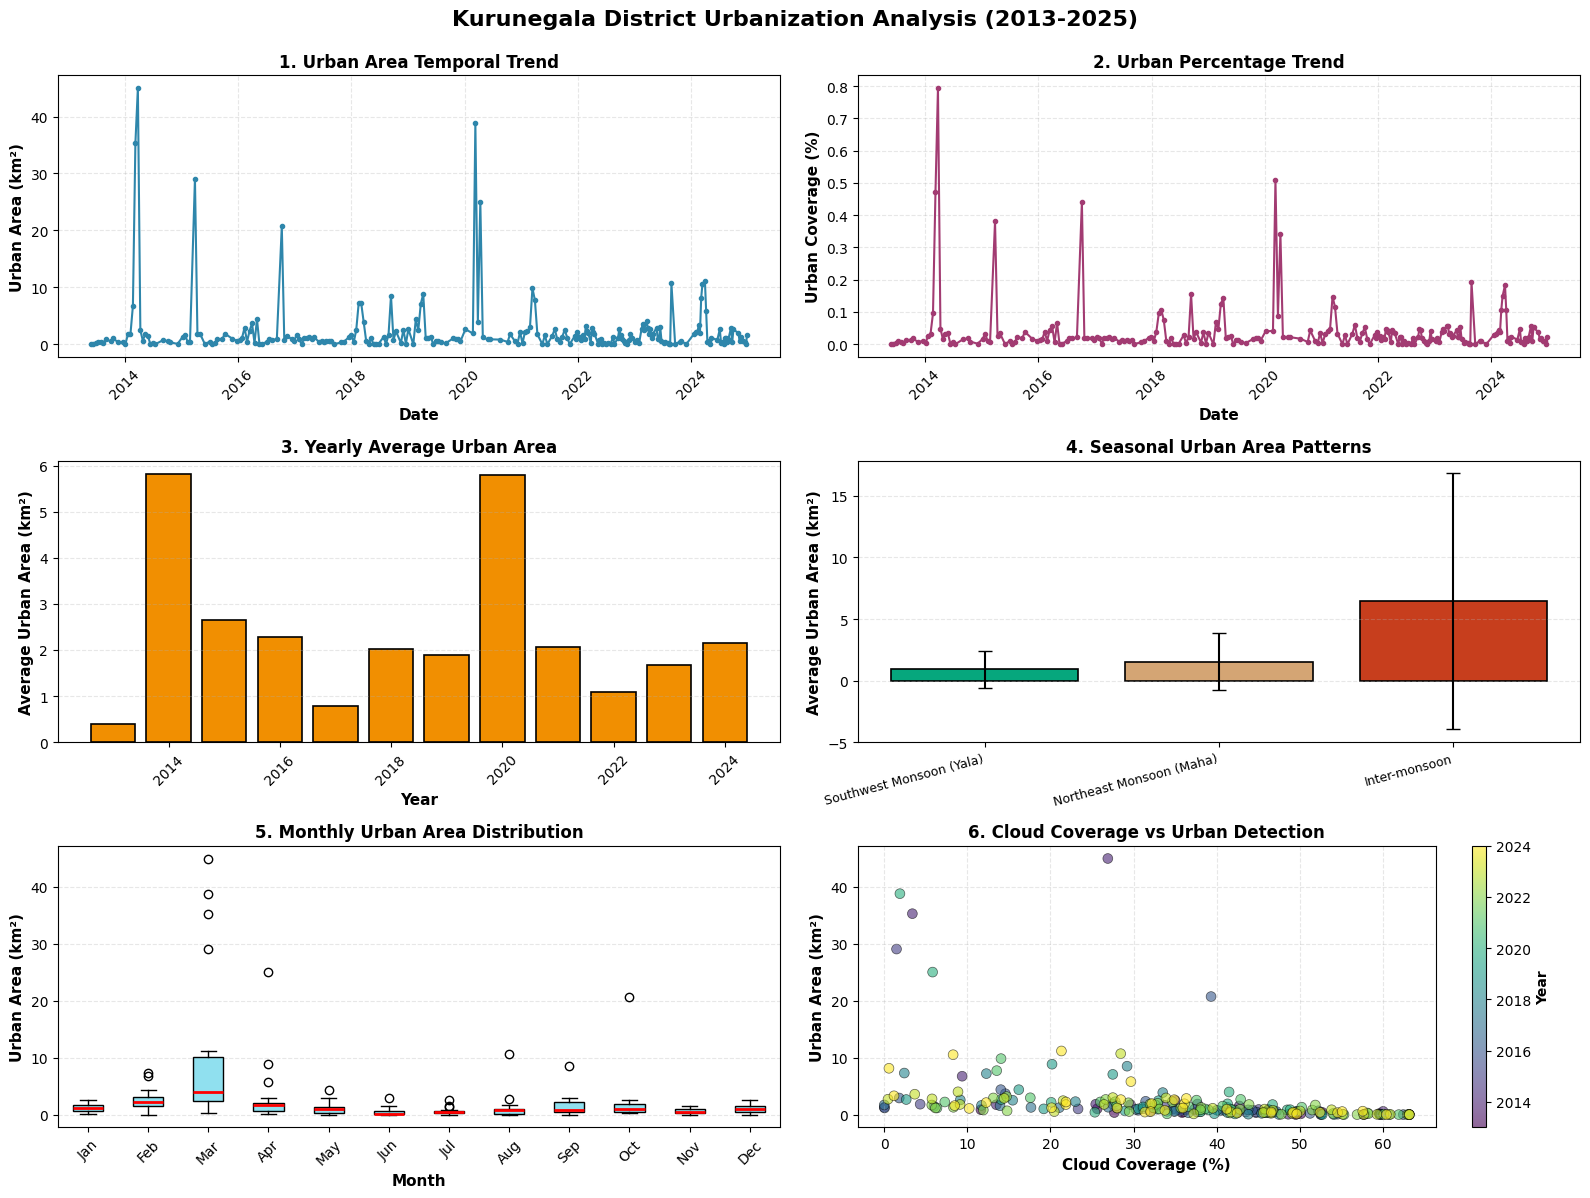


                         ADDITIONAL INSIGHTS                          

📈 Urban Growth Analysis:
   Initial average (2013): 0.39 km²
   Final average (2024): 2.15 km²
   Total growth: 1.76 km² (453.4%)
   Annual growth rate: 41.21%/year

🌦️  Seasonal Analysis:
   Southwest Monsoon (Yala): 0.93 km² (±1.51)
   Northeast Monsoon (Maha): 1.52 km² (±2.32)
   Inter-monsoon: 6.43 km² (±10.40)

✅ Data Quality Summary:
   Total scenes processed: 245
   Scenes per year: 20.4
   Years covered: 12
   Average valid pixels: 5596453
   Best quality scene: 2015-01-08 (0.0% cloud)

                          ANALYSIS COMPLETE!                          


In [2]:
# ===========================
# SAVE STATISTICS TO CSV
# ===========================

if stats:
    df = pd.DataFrame(stats)
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Save to CSV
    csv_path = os.path.join(OUTPUT_DIR, "Kurunegala_Urbanization_Stats.csv")
    df.to_csv(csv_path, index=False)
    
    print("\n" + "="*70)
    print("STATISTICS SAVED".center(70))
    print("="*70)
    print(f"✅ Statistics saved to: {csv_path}")
    print(f"   Total observations: {len(df)}")
    print(f"   Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"\n📊 Summary Statistics:")
    print(f"   Average urban area: {df['Urban_Area_km2'].mean():.2f} km²")
    print(f"   Min urban area: {df['Urban_Area_km2'].min():.2f} km² ({df.loc[df['Urban_Area_km2'].idxmin(), 'Date'].strftime('%Y-%m-%d')})")
    print(f"   Max urban area: {df['Urban_Area_km2'].max():.2f} km² ({df.loc[df['Urban_Area_km2'].idxmax(), 'Date'].strftime('%Y-%m-%d')})")
    print(f"   Average cloud coverage: {df['Cloud_Coverage'].mean():.1f}%")
    
    # ===========================
    # TEMPORAL VISUALIZATIONS
    # ===========================
    
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS".center(70))
    print("="*70)
    
    # Define Sri Lankan seasons
    def get_season(month):
        """Assign Sri Lankan monsoon season based on month"""
        if month in [5, 6, 7, 8, 9]:
            return 'Southwest Monsoon (Yala)'
        elif month in [10, 11, 12, 1, 2]:
            return 'Northeast Monsoon (Maha)'
        else:  # March, April
            return 'Inter-monsoon'
    
    df['Season'] = df['Month'].apply(get_season)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Kurunegala District Urbanization Analysis (2013-2025)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Urban Area Time Series
    ax1 = axes[0, 0]
    ax1.plot(df['Date'], df['Urban_Area_km2'], linewidth=1.5, color='#2E86AB', marker='o', markersize=3)
    ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Urban Area (km²)', fontsize=11, fontweight='bold')
    ax1.set_title('1. Urban Area Temporal Trend', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Urban Percentage over Time
    ax2 = axes[0, 1]
    ax2.plot(df['Date'], df['Urban_Percentage'], linewidth=1.5, color='#A23B72', marker='o', markersize=3)
    ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Urban Coverage (%)', fontsize=11, fontweight='bold')
    ax2.set_title('2. Urban Percentage Trend', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Yearly Average Urban Area
    ax3 = axes[1, 0]
    yearly_avg = df.groupby('Year')['Urban_Area_km2'].mean()
    ax3.bar(yearly_avg.index, yearly_avg.values, color='#F18F01', edgecolor='black', linewidth=1.2)
    ax3.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Average Urban Area (km²)', fontsize=11, fontweight='bold')
    ax3.set_title('3. Yearly Average Urban Area', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Seasonal Urban Area Distribution
    ax4 = axes[1, 1]
    season_stats = df.groupby('Season')['Urban_Area_km2'].agg(['mean', 'std'])
    season_order = ['Southwest Monsoon (Yala)', 'Northeast Monsoon (Maha)', 'Inter-monsoon']
    season_stats = season_stats.reindex(season_order)
    colors = ['#06A77D', '#D4A574', '#C73E1D']
    ax4.bar(range(len(season_stats)), season_stats['mean'], yerr=season_stats['std'], 
            color=colors, edgecolor='black', linewidth=1.2, capsize=5)
    ax4.set_xticks(range(len(season_stats)))
    ax4.set_xticklabels(season_stats.index, rotation=15, ha='right', fontsize=9)
    ax4.set_ylabel('Average Urban Area (km²)', fontsize=11, fontweight='bold')
    ax4.set_title('4. Seasonal Urban Area Patterns', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # 5. Monthly Urban Area Boxplot
    ax5 = axes[2, 0]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_data = [df[df['Month'] == m]['Urban_Area_km2'].values for m in range(1, 13)]
    bp = ax5.boxplot(monthly_data, labels=month_names, patch_artist=True,
                     boxprops=dict(facecolor='#90E0EF', edgecolor='black'),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'))
    ax5.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Urban Area (km²)', fontsize=11, fontweight='bold')
    ax5.set_title('5. Monthly Urban Area Distribution', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Cloud Coverage vs Urban Detection
    ax6 = axes[2, 1]
    scatter = ax6.scatter(df['Cloud_Coverage'], df['Urban_Area_km2'], 
                         c=df['Year'], cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax6.set_xlabel('Cloud Coverage (%)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Urban Area (km²)', fontsize=11, fontweight='bold')
    ax6.set_title('6. Cloud Coverage vs Urban Detection', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle='--')
    cbar = plt.colorbar(scatter, ax=ax6)
    cbar.set_label('Year', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(OUTPUT_DIR, "Urbanization_Analysis_Plots.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Visualizations saved to: {fig_path}")
    
    plt.show()
    
    # ===========================
    # ADDITIONAL ANALYSIS
    # ===========================
    
    print("\n" + "="*70)
    print("ADDITIONAL INSIGHTS".center(70))
    print("="*70)
    
    # Urban growth rate analysis
    if len(df) > 1:
        first_year = df.groupby('Year')['Urban_Area_km2'].mean().iloc[0]
        last_year = df.groupby('Year')['Urban_Area_km2'].mean().iloc[-1]
        years_span = df['Year'].max() - df['Year'].min()
        
        if years_span > 0:
            growth_rate = ((last_year - first_year) / first_year) * 100
            annual_growth = growth_rate / years_span
            
            print(f"\n📈 Urban Growth Analysis:")
            print(f"   Initial average ({df['Year'].min()}): {first_year:.2f} km²")
            print(f"   Final average ({df['Year'].max()}): {last_year:.2f} km²")
            print(f"   Total growth: {last_year - first_year:.2f} km² ({growth_rate:.1f}%)")
            print(f"   Annual growth rate: {annual_growth:.2f}%/year")
    
    # Seasonal insights
    print(f"\n🌦️  Seasonal Analysis:")
    for season in season_order:
        season_data = df[df['Season'] == season]
        if len(season_data) > 0:
            print(f"   {season}: {season_data['Urban_Area_km2'].mean():.2f} km² (±{season_data['Urban_Area_km2'].std():.2f})")
    
    # Data quality summary
    print(f"\n✅ Data Quality Summary:")
    print(f"   Total scenes processed: {len(df)}")
    print(f"   Scenes per year: {len(df) / len(df['Year'].unique()):.1f}")
    print(f"   Years covered: {len(df['Year'].unique())}")
    print(f"   Average valid pixels: {df['Valid_Pixels'].mean():.0f}")
    print(f"   Best quality scene: {df.loc[df['Cloud_Coverage'].idxmin(), 'Date'].strftime('%Y-%m-%d')} ({df['Cloud_Coverage'].min():.1f}% cloud)")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!".center(70))
    print("="*70)
    
else:
    print("\n⚠️  No statistics to save or visualize. Please check if scenes were processed successfully.")



             URBAN CHANGE DETECTION & EXPANSION ANALYSIS              

✅ Found 245 urban classification files

📅 Change Analysis Periods:
   Earliest: 2013-05-26
   Latest: 2024-12-26
   Time span: 11.6 years

📊 Change Statistics:
   Stable Non-Urban: 8,616,225 pixels
   Stable Urban: 13 pixels (0.01 km²)
   New Urbanization: 1,741 pixels (1.57 km²)
   De-urbanization: 1 pixels (0.00 km²)

   Total urban area (2013): 0.01 km²
   Total urban area (2024): 1.58 km²
   Net change: +1.57 km² (+12428.6%)
   Annual change rate: 0.14 km²/year

✅ Change map saved: D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly\Urban_Change_20130526_to_20241226.tif

                   GENERATING CHANGE VISUALIZATIONS                   

✅ Change visualization saved: D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly\Urban_Change_Visualization_2013_to_2024.png


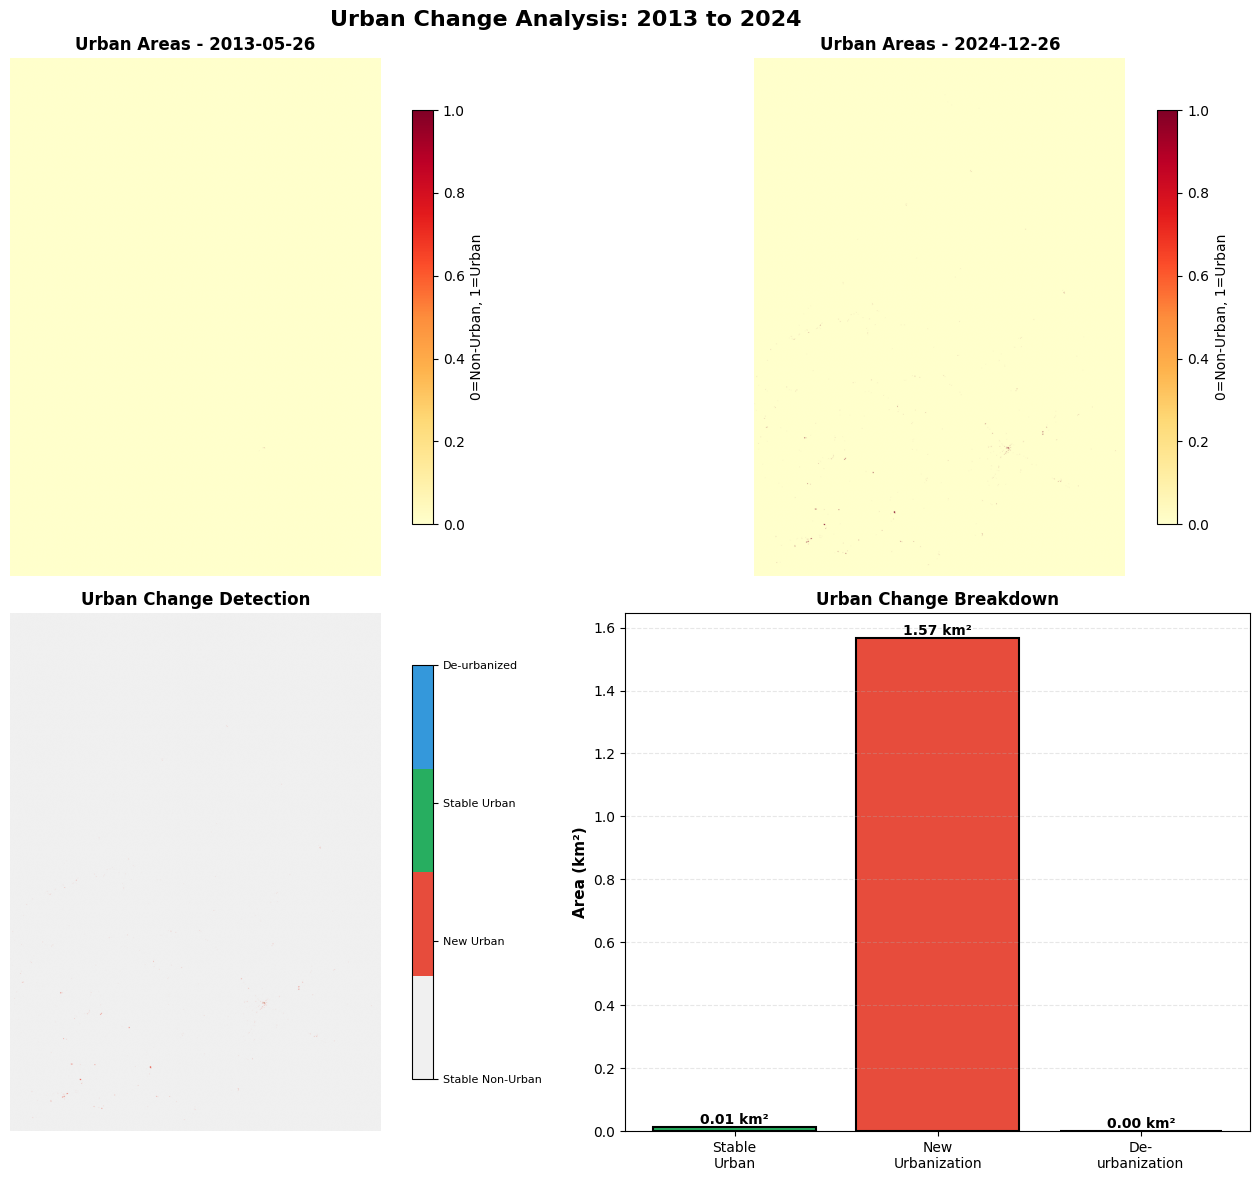


                MULTI-PERIOD URBAN EXPANSION ANALYSIS                 

📈 Year-to-Year Urban Expansion:
   2013 → 2014: +34.44 km² (+3977.3%)
   2014 → 2015: -34.03 km² (-96.4%)
   2015 → 2016: -0.11 km² (-8.3%)
   2016 → 2017: +0.53 km² (+45.2%)
   2017 → 2018: +5.60 km² (+330.0%)
   2018 → 2019: -4.65 km² (-63.7%)
   2019 → 2020: +36.17 km² (+1365.0%)
   2020 → 2021: -37.65 km² (-97.0%)
   2021 → 2022: +0.52 km² (+44.5%)
   2022 → 2023: +1.02 km² (+60.5%)
   2023 → 2024: +5.44 km² (+201.4%)

✅ Multi-year expansion chart saved: D:\Satellite Image Processing\Urbanization_Kurunegala\Processed_Monthly\Multi_Year_Urban_Expansion.png


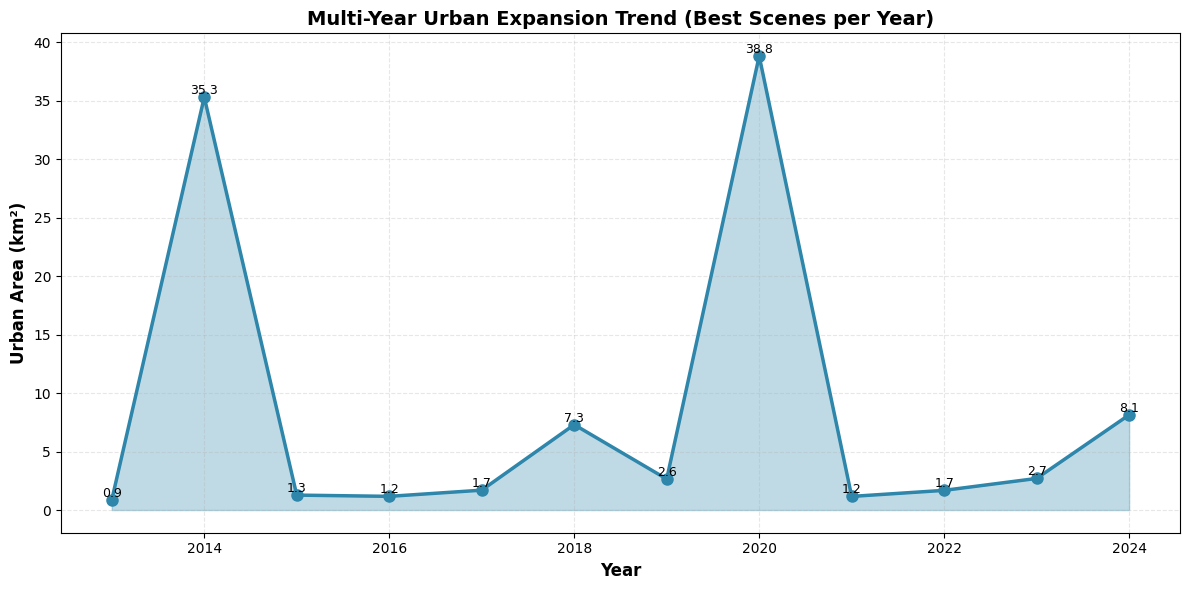


                      CHANGE DETECTION COMPLETE!                      


In [3]:
# ===========================
# URBAN CHANGE DETECTION
# ===========================

print("\n" + "="*70)
print("URBAN CHANGE DETECTION & EXPANSION ANALYSIS".center(70))
print("="*70)

# Find all urban classification files
urban_files = sorted(glob.glob(os.path.join(OUTPUT_DIR, "Urban_*.tif")))

if len(urban_files) >= 2:
    print(f"\n✅ Found {len(urban_files)} urban classification files")
    
    # Extract dates from filenames
    urban_dates = []
    for f in urban_files:
        filename = os.path.basename(f)
        date_str = filename.replace("Urban_", "").replace(".tif", "")
        try:
            date = datetime.strptime(date_str, "%Y%m%d")
            urban_dates.append((f, date))
        except:
            continue
    
    urban_dates.sort(key=lambda x: x[1])
    
    # Define change analysis periods
    # Compare earliest vs latest, and multi-year periods
    earliest_file, earliest_date = urban_dates[0]
    latest_file, latest_date = urban_dates[-1]
    
    print(f"\n📅 Change Analysis Periods:")
    print(f"   Earliest: {earliest_date.strftime('%Y-%m-%d')}")
    print(f"   Latest: {latest_date.strftime('%Y-%m-%d')}")
    print(f"   Time span: {(latest_date - earliest_date).days / 365.25:.1f} years")
    
    # Load earliest and latest urban maps
    with rasterio.open(earliest_file) as src:
        urban_early = src.read(1)
        meta = src.meta.copy()
    
    with rasterio.open(latest_file) as src:
        urban_late = src.read(1)
    
    # ===========================
    # CHANGE CLASSIFICATION
    # ===========================
    
    # Create change map
    # 0 = Stable Non-Urban (was 0, still 0)
    # 1 = New Urbanization (was 0, now 1) - EXPANSION
    # 2 = Stable Urban (was 1, still 1)
    # 3 = De-urbanization (was 1, now 0) - rare, possible data artifact
    
    change_map = np.zeros_like(urban_early, dtype=np.uint8)
    
    # Stable Non-Urban
    change_map[(urban_early == 0) & (urban_late == 0)] = 0
    
    # New Urbanization (EXPANSION)
    change_map[(urban_early == 0) & (urban_late == 1)] = 1
    
    # Stable Urban
    change_map[(urban_early == 1) & (urban_late == 1)] = 2
    
    # De-urbanization
    change_map[(urban_early == 1) & (urban_late == 0)] = 3
    
    # Calculate change statistics
    stable_nonurban = np.sum(change_map == 0)
    new_urban = np.sum(change_map == 1)
    stable_urban = np.sum(change_map == 2)
    deurbanized = np.sum(change_map == 3)
    
    new_urban_km2 = new_urban * 900 / 1e6
    stable_urban_km2 = stable_urban * 900 / 1e6
    deurbanized_km2 = deurbanized * 900 / 1e6
    
    total_early_km2 = np.sum(urban_early == 1) * 900 / 1e6
    total_late_km2 = np.sum(urban_late == 1) * 900 / 1e6
    net_change_km2 = total_late_km2 - total_early_km2
    
    print(f"\n📊 Change Statistics:")
    print(f"   Stable Non-Urban: {stable_nonurban:,} pixels")
    print(f"   Stable Urban: {stable_urban:,} pixels ({stable_urban_km2:.2f} km²)")
    print(f"   New Urbanization: {new_urban:,} pixels ({new_urban_km2:.2f} km²)")
    print(f"   De-urbanization: {deurbanized:,} pixels ({deurbanized_km2:.2f} km²)")
    print(f"\n   Total urban area ({earliest_date.year}): {total_early_km2:.2f} km²")
    print(f"   Total urban area ({latest_date.year}): {total_late_km2:.2f} km²")
    print(f"   Net change: {net_change_km2:+.2f} km² ({(net_change_km2/total_early_km2)*100:+.1f}%)")
    
    if (latest_date - earliest_date).days > 0:
        annual_change = net_change_km2 / ((latest_date - earliest_date).days / 365.25)
        print(f"   Annual change rate: {annual_change:.2f} km²/year")
    
    # Save change map
    meta.update(dtype=rasterio.uint8)
    change_file = os.path.join(OUTPUT_DIR, f"Urban_Change_{earliest_date.strftime('%Y%m%d')}_to_{latest_date.strftime('%Y%m%d')}.tif")
    with rasterio.open(change_file, "w", **meta) as dst:
        dst.write(change_map, 1)
    
    print(f"\n✅ Change map saved: {change_file}")
    
    # ===========================
    # CHANGE VISUALIZATION
    # ===========================
    
    print("\n" + "="*70)
    print("GENERATING CHANGE VISUALIZATIONS".center(70))
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Urban Change Analysis: {earliest_date.strftime("%Y")} to {latest_date.strftime("%Y")}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Early Period Urban Map
    ax1 = axes[0, 0]
    im1 = ax1.imshow(urban_early, cmap='YlOrRd', vmin=0, vmax=1)
    ax1.set_title(f'Urban Areas - {earliest_date.strftime("%Y-%m-%d")}', fontsize=12, fontweight='bold')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='0=Non-Urban, 1=Urban', shrink=0.8)
    
    # 2. Late Period Urban Map
    ax2 = axes[0, 1]
    im2 = ax2.imshow(urban_late, cmap='YlOrRd', vmin=0, vmax=1)
    ax2.set_title(f'Urban Areas - {latest_date.strftime("%Y-%m-%d")}', fontsize=12, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='0=Non-Urban, 1=Urban', shrink=0.8)
    
    # 3. Change Map
    ax3 = axes[1, 0]
    from matplotlib.colors import ListedColormap
    colors = ['#f0f0f0', '#e74c3c', '#27ae60', '#3498db']  # Gray, Red, Green, Blue
    cmap_change = ListedColormap(colors)
    im3 = ax3.imshow(change_map, cmap=cmap_change, vmin=0, vmax=3)
    ax3.set_title('Urban Change Detection', fontsize=12, fontweight='bold')
    ax3.axis('off')
    cbar3 = plt.colorbar(im3, ax=ax3, ticks=[0, 1, 2, 3], shrink=0.8)
    cbar3.ax.set_yticklabels(['Stable Non-Urban', 'New Urban', 'Stable Urban', 'De-urbanized'], fontsize=8)
    
    # 4. Change Statistics Bar Chart
    ax4 = axes[1, 1]
    categories = ['Stable\nUrban', 'New\nUrbanization', 'De-\nurbanization']
    values = [stable_urban_km2, new_urban_km2, deurbanized_km2]
    colors_bar = ['#27ae60', '#e74c3c', '#3498db']
    bars = ax4.bar(categories, values, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Area (km²)', fontsize=11, fontweight='bold')
    ax4.set_title('Urban Change Breakdown', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} km²',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save change visualization
    change_viz_file = os.path.join(OUTPUT_DIR, f"Urban_Change_Visualization_{earliest_date.strftime('%Y')}_to_{latest_date.strftime('%Y')}.png")
    plt.savefig(change_viz_file, dpi=300, bbox_inches='tight')
    print(f"\n✅ Change visualization saved: {change_viz_file}")
    
    plt.show()
    
    # ===========================
    # MULTI-PERIOD ANALYSIS
    # ===========================
    
    # Analyze change across multiple periods if data spans multiple years
    years_available = sorted(set([d[1].year for d in urban_dates]))
    
    if len(years_available) >= 3:
        print("\n" + "="*70)
        print("MULTI-PERIOD URBAN EXPANSION ANALYSIS".center(70))
        print("="*70)
        
        yearly_urban_area = []
        
        for year in years_available:
            # Find best (least cloudy) scene for each year from stats
            if 'df' in locals():
                year_scenes = df[df['Year'] == year]
                if len(year_scenes) > 0:
                    # Get scene with lowest cloud coverage for this year
                    best_scene = year_scenes.loc[year_scenes['Cloud_Coverage'].idxmin()]
                    yearly_urban_area.append({
                        'Year': year,
                        'Urban_Area_km2': best_scene['Urban_Area_km2'],
                        'Date': best_scene['Date']
                    })
        
        if len(yearly_urban_area) >= 2:
            # Create year-to-year change analysis
            print(f"\n📈 Year-to-Year Urban Expansion:")
            for i in range(1, len(yearly_urban_area)):
                prev = yearly_urban_area[i-1]
                curr = yearly_urban_area[i]
                change = curr['Urban_Area_km2'] - prev['Urban_Area_km2']
                change_pct = (change / prev['Urban_Area_km2']) * 100
                print(f"   {prev['Year']} → {curr['Year']}: {change:+.2f} km² ({change_pct:+.1f}%)")
            
            # Plot multi-year expansion
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            years = [y['Year'] for y in yearly_urban_area]
            areas = [y['Urban_Area_km2'] for y in yearly_urban_area]
            
            ax.plot(years, areas, marker='o', markersize=8, linewidth=2.5, color='#2E86AB')
            ax.fill_between(years, areas, alpha=0.3, color='#2E86AB')
            ax.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax.set_ylabel('Urban Area (km²)', fontsize=12, fontweight='bold')
            ax.set_title('Multi-Year Urban Expansion Trend (Best Scenes per Year)', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add value labels
            for year, area in zip(years, areas):
                ax.text(year, area, f'{area:.1f}', ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            expansion_file = os.path.join(OUTPUT_DIR, "Multi_Year_Urban_Expansion.png")
            plt.savefig(expansion_file, dpi=300, bbox_inches='tight')
            print(f"\n✅ Multi-year expansion chart saved: {expansion_file}")
            plt.show()
    
    print("\n" + "="*70)
    print("CHANGE DETECTION COMPLETE!".center(70))
    print("="*70)
    
else:
    print(f"\n⚠️  Insufficient data for change detection. Found only {len(urban_files)} urban classification file(s).")
    print("    At least 2 files are needed for temporal change analysis.")
